In [111]:
from importlib import reload
import numpy as np
import os
from scipy.sparse import csc_matrix, csr_matrix
import pickle
import pretty_midi
import sys
import copy
from collections import namedtuple
import timeit
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [112]:
# import modules, including a reload statement so that they can be reimported after a change to the methods 
import src.midi_utils as midi_utils
reload(midi_utils)

import src.data as data
reload(data)

import src.models as models
reload(models)

import src.ml_classes as ml_classes
reload(ml_classes)

<module 'src.ml_classes' from 'C:\\Users\\Andrew\\Documents\\mlprojects\\781-piano-autoencoder\\src\\ml_classes.py'>

# Data Exploration
This notebook contains the code needed to make the plots found in the project report, and a few other plots besides. This includes comparisons of training and validation loss for different model configurations.

## Offsets
As it turns out, I play quite ahead of the beat...

In [11]:
# load data (non sparse)
with open('training_data/model_datas_non_sparse_03-04', 'rb') as f:
    model_datas = pickle.load(f)

Text(0, 0.5, 'Frequency')

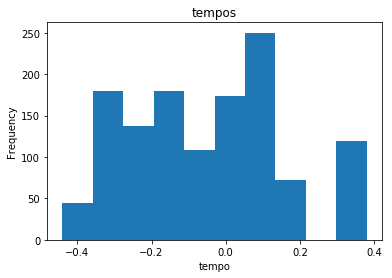

In [51]:
# plot frequency of different tempo examples
plt.hist(model_datas['tempo'].data)
plt.title('tempos')
plt.xlabel('tempo')
plt.ylabel('Frequency')

In [53]:
# get the offsets
slow_examples = np.where(model_datas['tempo'].data < -0.1)[0]
fast_examples = np.where(model_datas['tempo'].data >= -0.1)[0]

offsets = model_datas['O'].data[np.where(model_datas['O'].data != 0)]
offsets_slow = model_datas['O'].data[slow_examples][np.where(model_datas['O'].data[slow_examples] != 0)]
offsets_fast = model_datas['O'].data[fast_examples][np.where(model_datas['O'].data[fast_examples] != 0)]

# get the mean offset
print('Average offset:', np.mean(offsets))
print('Average offset (slow):', np.mean(offsets_slow))
print('Average offset (fast):', np.mean(offsets_fast))
# np.mean(model_datas['O'].data[np.where(model_datas['O'].data != 0)])

Average offset: -0.2159549405151239
Average offset (slow): -0.2122750100740251
Average offset (fast): -0.21921260114292063


### Plotting note offsets
Ideally the distribution would be centered at zero - it's not!

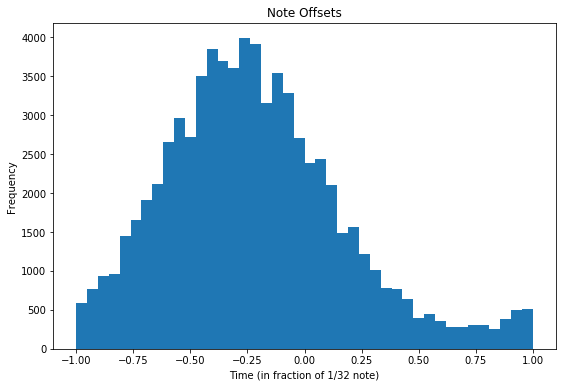

In [58]:
plt.figure(figsize=(9,6))
# plt.yscale('log')
plt.hist(offsets, bins=42)
plt.title('Note Offsets')
plt.xlabel('Time (in fraction of 1/32 note)')
plt.ylabel('Frequency')
plt.savefig('evidence')

### Plotting note offsets by tempo
It is much worse for faster tempos

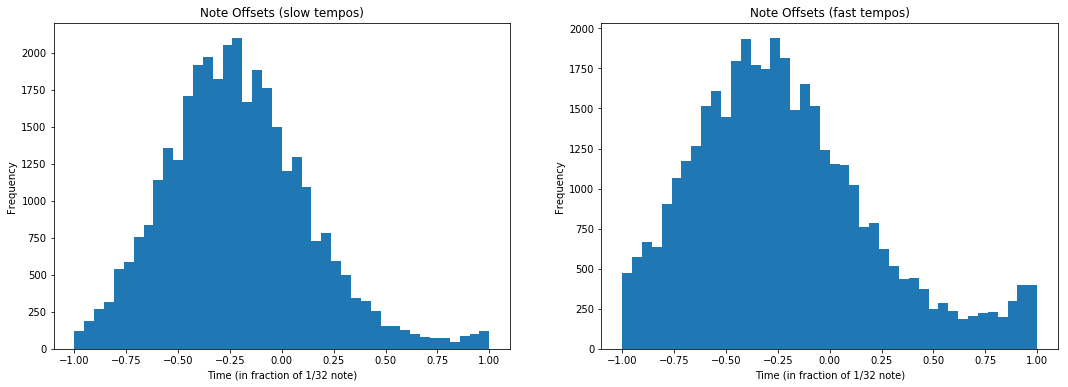

In [49]:
slow_examples = np.where(model_datas['tempo'].data < -0.1)[0]
fast_examples = np.where(model_datas['tempo'].data >= -0.1)[0]
offsets_slow = model_datas['O'].data[slow_examples][np.where(model_datas['O'].data[slow_examples] != 0)]
offsets_fast = model_datas['O'].data[fast_examples][np.where(model_datas['O'].data[fast_examples] != 0)]

plt.figure(figsize=(18,6))
plt.subplot(121)

# plt.xlim((0,36))
plt.hist(offsets_slow, bins=42)
# plt.yscale('log')
plt.title('Note Offsets (slow tempos)')
plt.xlabel('Time (in fraction of 1/32 note)')
plt.ylabel('Frequency')

plt.subplot(122)
# plt.xlim((0,36))
plt.hist(offsets_fast, bins=42)
# plt.yscale('log')
plt.title('Note Offsets (fast tempos)')
plt.xlabel('Time (in fraction of 1/32 note)')
plt.ylabel('Frequency')
plt.savefig('fastVSslow')

## Returning to midi format
This code generates some midi files for random training examples.  
Assumes all information is present, including pedal etc.

In [ ]:
# given complete set of model datas, go back to midi format
for i in range(5):
    pm =data.examples2pm(model_datas)
    pm.write(f'test{i}.mid')

## Pitch/Beat/Velocity Relationships
### Velocity and Pitch Class

In [61]:
# load data that is all in the same key (non sparse)
with open('training_data/model_datas_non_sparse_base_key_03-04', 'rb') as f:
    model_datas = pickle.load(f)

In [ ]:
# velocity by pitch class
note_indices = np.where(model_datas['H'].data != 0)
v_by_pitch = [[] for _ in range(12)]
for idx in zip(*note_indices):
    v_by_pitch[idx[-1] % 12].append(model_datas['V'].data[idx])

<Figure size 1296x432 with 0 Axes>

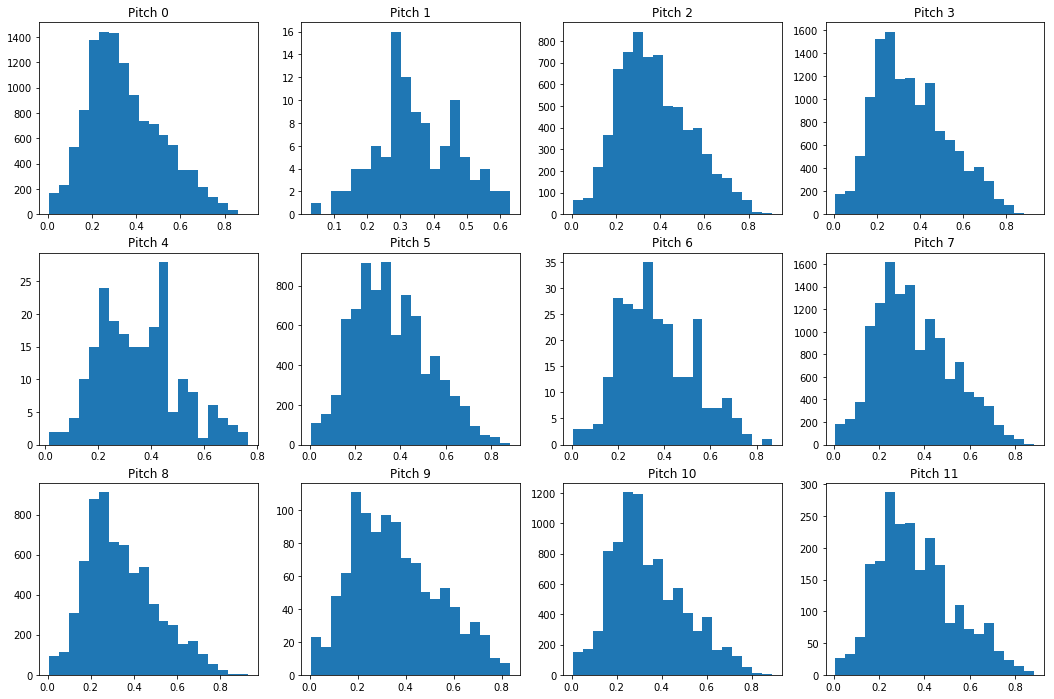

In [91]:
# plot velocities by pitch class
fig, ax = plt.subplots(nrows=3,ncols=4, figsize=(18,12))
ax = [a for sublist in ax for a in sublist]
for i in range(len(v_by_pitch)):
    ax[i].hist(v_by_pitch[i], bins=20)
    ax[i].set_title(f'Pitch {i}')

### Velocities and Beats

In [99]:
# velocity by beat
note_indices = np.where(model_datas['H'].data != 0)

v_by_beat_sub_beats = [[] for _ in range(4)]
for idx in zip(*note_indices):
    v_by_beat_sub_beats[idx[-2] % 4].append(model_datas['V'].data[idx])
    
v_by_bar_sub_beats = [[] for _ in range(16)]
for idx in zip(*note_indices):
    v_by_bar_sub_beats[idx[-2] % 16].append(model_datas['V'].data[idx])

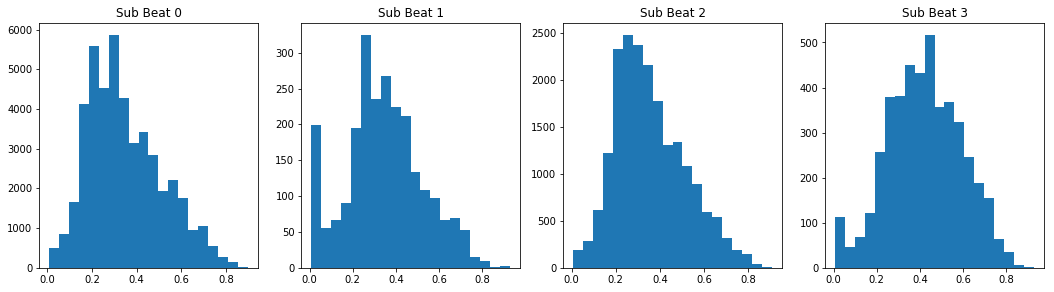

In [102]:
# plot velocities by beat sub beats
fig, ax = plt.subplots(nrows=1,ncols=4, figsize=(18,4.5))
for i in range(len(v_by_beat_sub_beats)):
    ax[i].hist(v_by_beat_sub_beats[i], bins=20)
    ax[i].set_title(f'Sub Beat {i+1}')

The mode of sub beat 4 is much higher than any others, even though it is the most 'minor' beat.

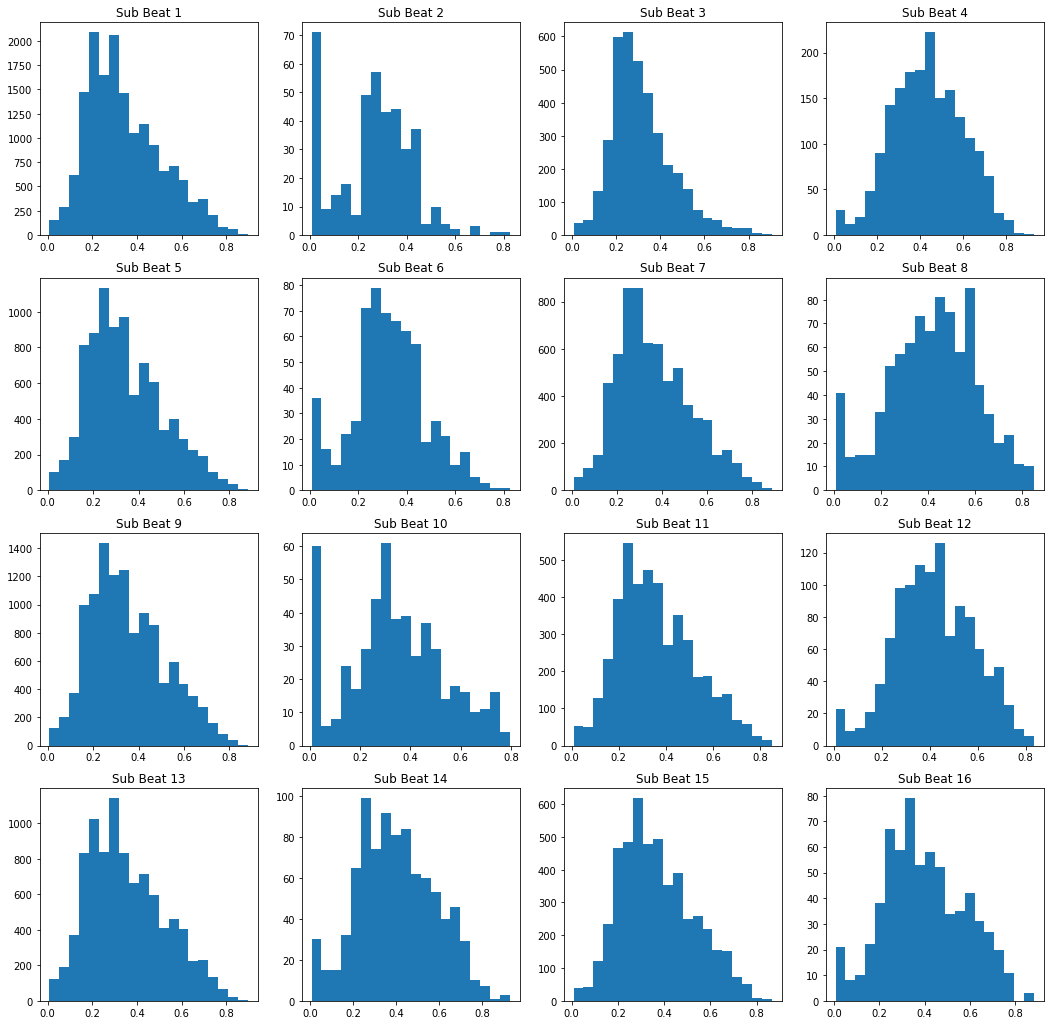

In [104]:
# plot velocities by bar sub beats
fig, ax = plt.subplots(nrows=4,ncols=4, figsize=(18,18))
ax = [a for sublist in ax for a in sublist]
for i in range(len(v_by_bar_sub_beats)):
    ax[i].hist(v_by_bar_sub_beats[i], bins=20)
    ax[i].set_title(f'Sub Beat {i+1}')

Notice the differing scales on y axes. There is precisely the kind of musical hierarchy we would expect:  
- Sub beat 1, the down beat, has by far the most notes, followed by sub beat 3.  
- Within beats (each row), the first sub beat has the most hits, followed by the third.  

### Pitch Class and Beats

In [ ]:
# velocity by pitch class
note_indices = np.where(model_datas['H'].data != 0)
pitch_by_beat = [[] for _ in range()]
for idx in zip(*note_indices):
    v_by_pitch[idx[-1] % 12].append(model_datas['V'].data[idx])

### Generate plots of offset distributions for each file

In [ ]:
files = [file for file in os.scandir('training_data_v0/midi_files')]
print(type(files[i]))
for i, file in enumerate(files):
    if i % 5 == 0:
        print(f'file {i} of {len(files)}')
    pm = pretty_midi.PrettyMIDI(file.path)
    key = data.filepath2key(file.path)
    examples = midi_utils.pm2example(pm, key=key, sparse=False)
    offsets = examples['O'][np.where(examples['H'] != 0)]
    plt.figure(figsize=(9,6))
    # plt.yscale('log')
    plt.hist(offsets, bins=42)
    plt.title('Note Offsets')
    plt.xlabel('Time (in fraction of 1/32 note)')
    plt.ylabel('Frequency')
    plt.savefig(f'training_data/offsets/plt{i}')

Try centering these plots, by centering the midi files

<class 'nt.DirEntry'>
file 0 of 19
file 5 of 19
file 10 of 19
file 15 of 19


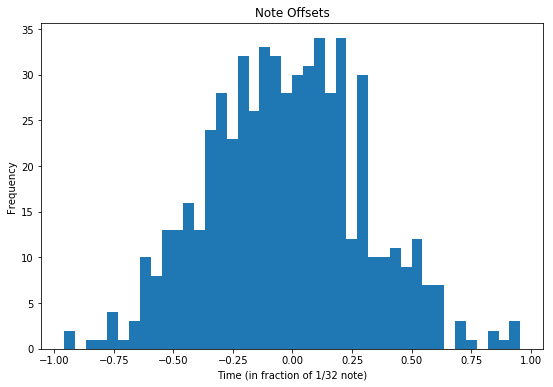

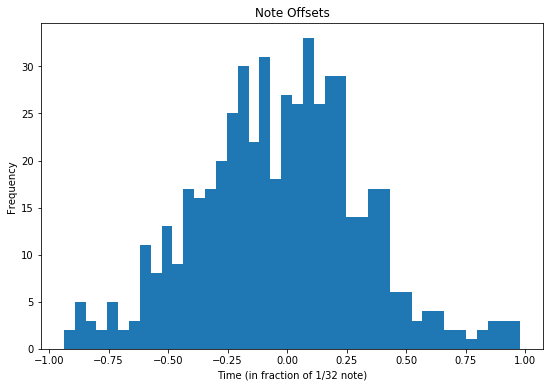

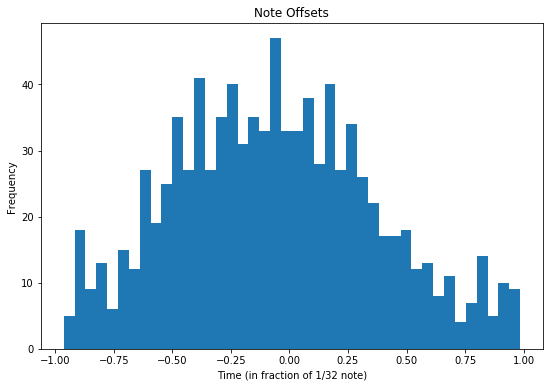

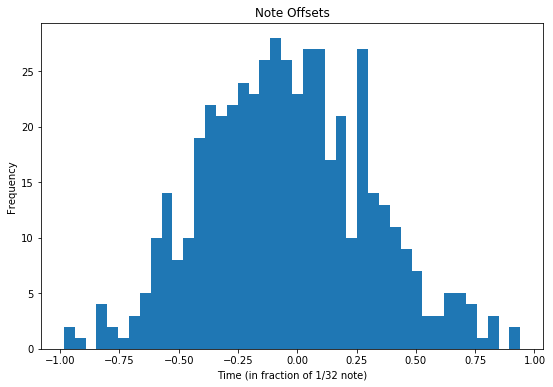

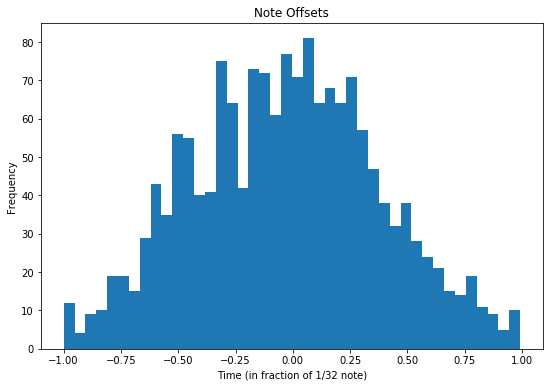

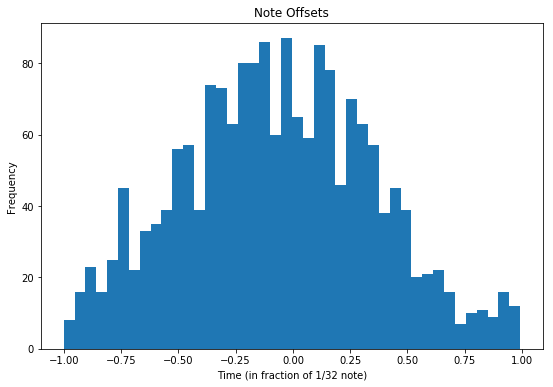

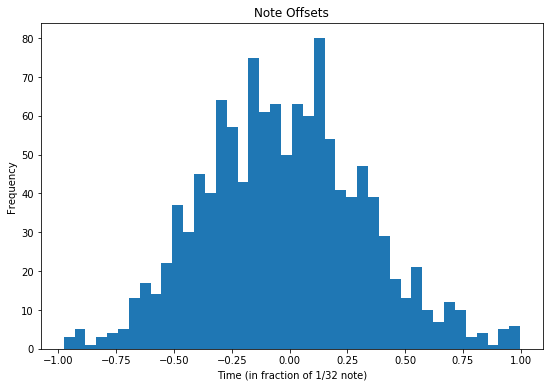

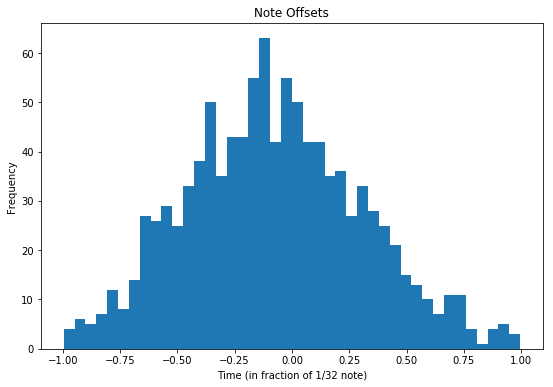

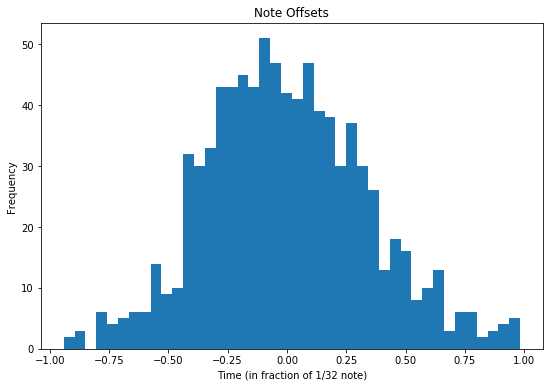

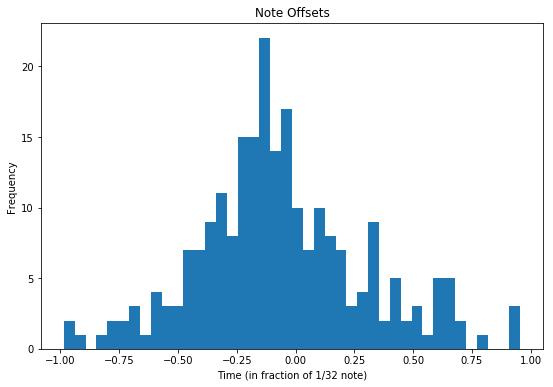

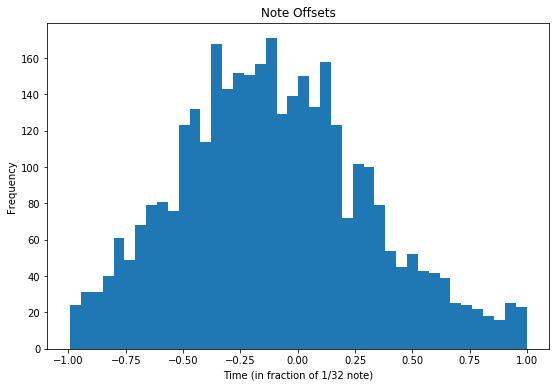

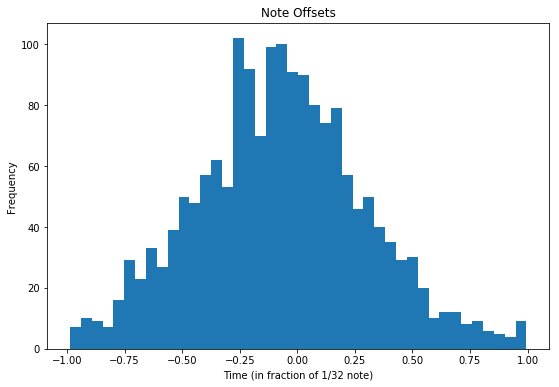

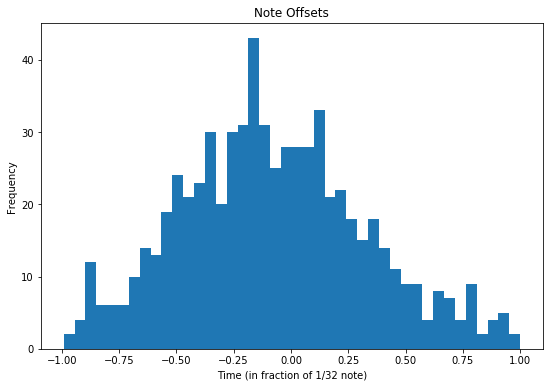

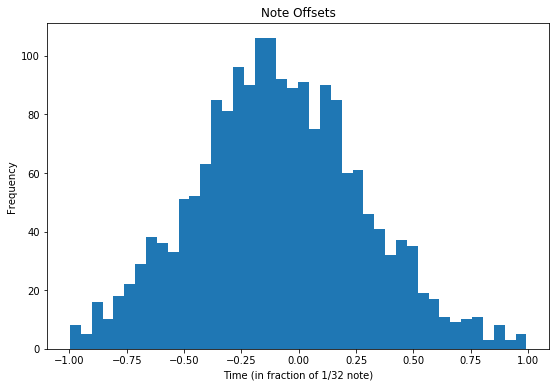

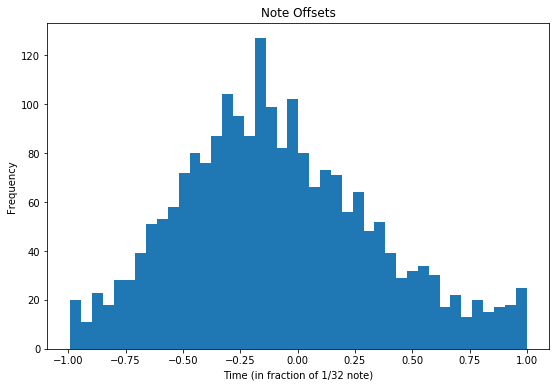

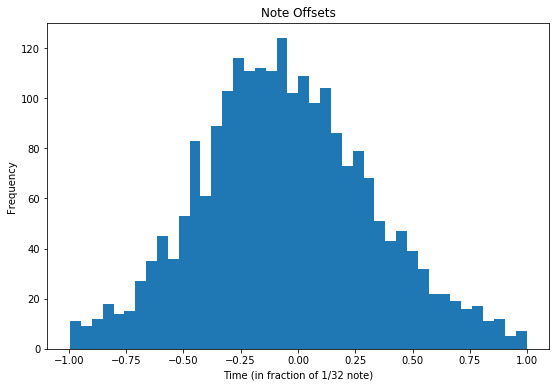

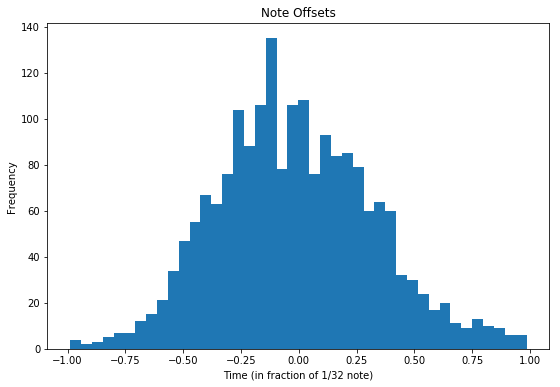

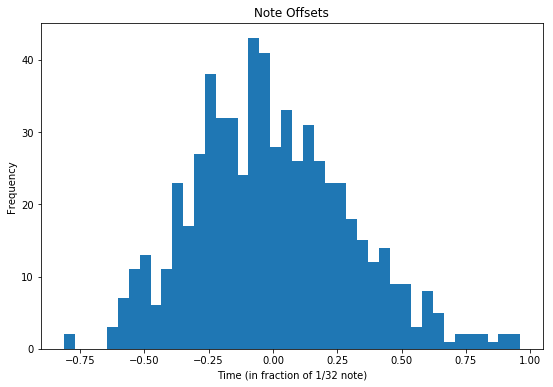

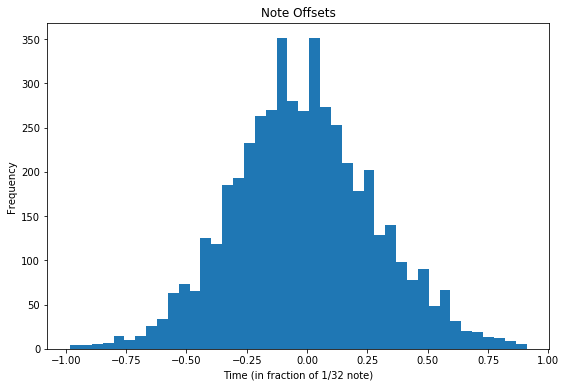

In [118]:
sub_beats=4
files = [file for file in os.scandir('training_data_v0/midi_files')]
print(type(files[i]))
for i, file in enumerate(files):
    if i % 5 == 0:
        print(f'file {i} of {len(files)}')
    pm = pretty_midi.PrettyMIDI(file.path)
    
    beat_length = 60 / pm.get_tempo_changes()[-1][0]
    sub_beat_length = beat_length / sub_beats
    max_offset = sub_beat_length / 2
    offsets = []
    # get all offsets (distance to nearest subbeat)
    for note in pm.instruments[0].notes:
        # time since last sub beat
        offset = note.start % sub_beat_length
        # are we closer to the last sub beat, or next sub beat? 
        if offset > max_offset:
            offset = offset - sub_beat_length
        offsets.append(offset)

    mean_offset = np.mean(offsets)

    for note in pm.instruments[0].notes:
        note.start -= mean_offset
        note.end -= mean_offset
    for cc in pm.instruments[0].control_changes:
        cc.time -= mean_offset
    
    key = data.filepath2key(file.path)
    examples = midi_utils.pm2example(pm, key=key, sparse=False)
    offsets = examples['O'][np.where(examples['H'] != 0)]
    plt.figure(figsize=(9,6))
    # plt.yscale('log')
    plt.hist(offsets, bins=42)
    plt.title('Note Offsets')
    plt.xlabel('Time (in fraction of 1/32 note)')
    plt.ylabel('Frequency')
    plt.savefig(f'training_data/offsets/plt{i}centered')

## Other Graphing
Some graphing code from the summer project. Some will be used to plot model performance for this project too.

In [59]:
#### Graphing note lengths and durations
lengths = []
shifts = []

files = [file for file in os.scandir('training_data_v0/midi_files')]
for i in range(len(files)):
    if i % 20 == 0:
        print(f'file {i} of {len(files)}')
    pm = pretty_midi.PrettyMIDI(files[i].path)
    midi_utils.sustain_only(pm)
    midi_utils.desus(pm)
    pm.instruments[0].notes.sort(key = lambda x: x.start)
    last_note_start = 0
    for note in pm.instruments[0].notes:
        lengths.append(note.end - note.start)
        shifts.append(note.start - last_note_start)
        last_note_start = note.start

file 0 of 19


In [ ]:
for i in :
    print(i)

In [73]:
for i in *note_indices:
    print(i)

SyntaxError: invalid syntax (<ipython-input-73-7cb45cbd7968>, line 1)

In [46]:
# fraction of lengths or durations longer than a particular value
print(sum(np.array(lengths) > 10) / len(lengths))
print(sum(np.array(shifts) > 10) / len(shifts))

0.0038518981897798805
5.7864487625601126e-05


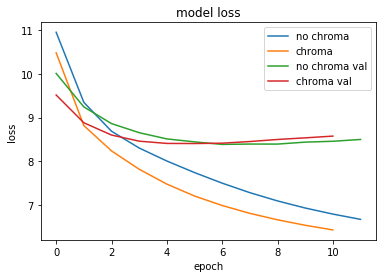

In [2]:
# First experiment showing chroma works.
import ast
with open(f'models/nbc/nbcmodel3/history40e.json', 'r') as f:
    hist = ast.literal_eval(json.load(f))
with open(f'models/nbc/nbcmodel4/history40e.json', 'r') as f:
    hist2 = ast.literal_eval(json.load(f))
metric = 'loss'
# print(hist)
plt.plot(hist[metric])
plt.plot(hist2[metric])
plt.plot(hist['val_' + metric])
plt.plot(hist2['val_' + metric])
plt.title('model ' + metric)
plt.ylabel(metric)
plt.xlabel('epoch')
plt.legend(['no chroma', 'chroma', 'no chroma val', 'chroma val'], loc='upper right')
plt.savefig('?')
plt.show()

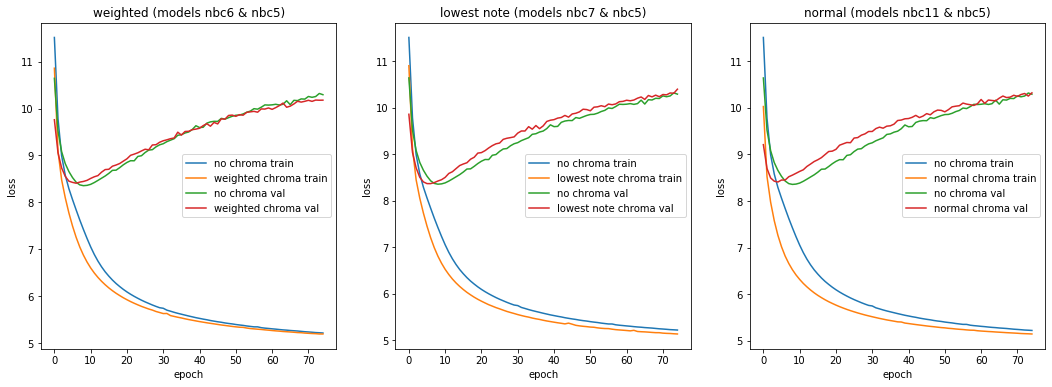

In [52]:
# Comparison of the four different chroma schemes with no chroma
chroma_type = {6: 'weighted', 7: 'lowest note', 11: 'normal'}
graph_pos = 131
plt.figure(figsize=(18,6))
for no, chroma in chroma_type.items():
    with open(f'models/nbc/nbcmodel5/history75e.json', 'r') as f:
        hist = ast.literal_eval(json.load(f))
    with open(f'models/nbc/nbcmodel{no}/history75e.json', 'r') as f:
        hist2 = ast.literal_eval(json.load(f))
    plt.subplot(graph_pos)
    graph_pos += 1
    metric = 'loss'
    # print(hist)
    plt.plot(hist[metric])
    plt.plot(hist2[metric])
    plt.plot(hist['val_' + metric])
    plt.plot(hist2['val_' + metric])
    plt.title(chroma + f' (models nbc{no} & nbc5)')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['no chroma train', chroma + ' chroma train', 'no chroma val', chroma + ' chroma val'], loc='right')
# plt.savefig('?')
plt.show()

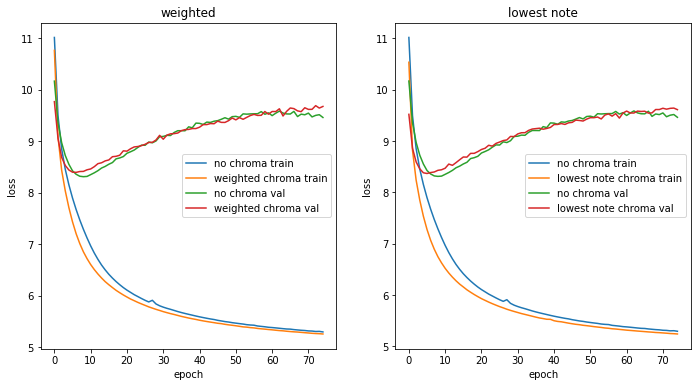

In [4]:
# Comparison of weighted and lowest note, when transposition is applied.
chroma_type = {9: 'weighted', 10: 'lowest note'}
graph_pos = 131
plt.figure(figsize=(18,6))
for no, chroma in chroma_type.items():
    with open(f'models/nbc/nbcmodel8/history75e.json', 'r') as f:
        hist = ast.literal_eval(json.load(f))
    with open(f'models/nbc/nbcmodel{no}/history75e.json', 'r') as f:
        hist2 = ast.literal_eval(json.load(f))
    plt.subplot(graph_pos)
    graph_pos += 1
    metric = 'loss'
    # print(hist)
    plt.plot(hist[metric])
    plt.plot(hist2[metric])
    plt.plot(hist['val_' + metric])
    plt.plot(hist2['val_' + metric])
    plt.title(chroma)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['no chroma train', chroma + ' chroma train', 'no chroma val', chroma + ' chroma val'], loc='right')
# plt.savefig('?')
plt.show()

9.335865358027016
10.52765391512615


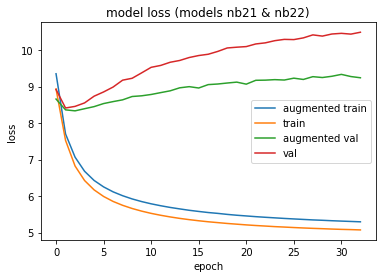

In [53]:
# comparison of nbmodel 21 with 22, showing that augmentation reduces overfitting
with open(f'models/nb/nbmodel21/history33e.json', 'r') as f:
    hist33 = ast.literal_eval(json.load(f))
with open(f'models/nb/nbmodel22/history99e.json', 'r') as f:
    hist99 = ast.literal_eval(json.load(f))

new_hist99 = {}
for key, value in hist99.items():
    new_hist99[key] = [v for i, v in enumerate(value) if i % 3 == 1]

print(max(hist33['val_loss']))
print(max(hist99['val_loss']))
metric = 'loss'
plt.plot(hist33[metric])
plt.plot(new_hist99[metric])
plt.plot(hist33['val_' + metric])
plt.plot(new_hist99['val_' + metric])
plt.title('model ' + metric + ' (models nb21 & nb22)')
plt.ylabel(metric)
plt.xlabel('epoch')
plt.legend(['augmented train', 'train', 'augmented val', 'val'], loc='right')
# plt.savefig('?')
plt.show()

In [ ]:
# plot loss for each note attribute - could check out how augmentation affects each attribute individually
metric = 'loss'
# print(hist)
plt.plot(hist['dense_1_' + metric])
plt.plot(hist['dense_2_' + metric])
plt.plot(hist['dense_3_' + metric])
plt.plot(hist['dense_4_' + metric])
plt.plot(hist['dense_5_' + metric])
plt.plot(hist['dense_' + metric])
plt.title('model ' + metric)
plt.ylabel(metric)
plt.xlabel('epoch')
plt.legend([f'dense_{i}' + metric for i in range(1,6)], loc='upper left')
plt.show()